In [ ]:
import os
import sys

PROJECT_PATH = os.path.dirname(os.getcwd())
sys.path.append(PROJECT_PATH)
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from typing import Dict
from lsbd_vae.models.architectures import get_encoder_decoder
from lsbd_vae.data_utils.data_loader import load_factor_data
from experiments.configs.paper_dataset_parameters import return_data_parameters
from lsbd_vae.data_utils.factor_dataset import FactorImageDataset
from lsbd_vae.utils.model_utils import get_ls_list, get_autoencoder_model
from lsbd_vae.utils.plotting import plot_subset, plot_objects_pca, plot_data_examples_grid, image_scatter
from lsbd_vae.metrics.dlsbd_metric import create_combinations_omega_values_range, dlsbd

TORUS_DATASETS = {"arrow", "pixel4", "modelnet_colors", "pixel8", "pixel16"}
CYLINDER_DATASETS = {"coil100", "modelnet40_airplanes"}

# Dataset Loading
Images in the datasets are loaded into instances of a class called FactorImageDataset which has methods and properties that take into account the underlying subgroup structure of the data.

In [ ]:
# Define the name of the dataset
dataset: str = "modelnet40_airplanes"
# Get the parameters used to load the data
data_parameters: Dict = return_data_parameters(dataset)
# Use util function to load the data. The data is loaded into an instance of the class FactorImageDataset
data_class: FactorImageDataset = load_factor_data(**data_parameters)

## Dataset Images
The dataset class contains a property called *images* with all available data created from the actions of the group
 $G = G_1\times G_2\times \cdot G_K$ where each $G_k$ with $k\in\{1,2,\ldots, K\}$ is a subgroup of $G$.
In our experiment we usually use $K=2$ subgroups at most.
The total number of images available is $N = \prod_{k=1}^K|G_K|$.

In [ ]:
print(
    "Shape of the dataset images {} with: \n- {} elements corresponding to subgroup 1 \n- {} elements corresponding to sugbroup 2"
    " \n- {} height \n- {} width  \n- {} channels \nTotal data {} N =  images".format(data_class.images.shape,
                                                                                      *data_class.images.shape,
                                                                                      np.product(
                                                                                          data_class.images.shape[
                                                                                          :-3])))

## Plot examples
We can inspect the data that we have loaded. We will visualize it in a grid of images. In this grid along the vertical direction, for a fixed column, only a single factor changes through the actions of the first subgroup $G_1$. In the case of the arrow dataset we see that the arrow rotates counter-clockwise.
Along the horizontal direction, for a fixed row, we can see the actions of the second subgroup $G_2$ (periodic change in the colour).


In [ ]:
fig, _ = plot_data_examples_grid(7, data_class, "binary_r")



## Dataset Factors
The true factor values that describe each of the images are stored in the *factor_mesh* property.

In [ ]:
print(f"Names of the underlying factors {data_class.factor_names}")
print(f"Factor mesh shape {data_class.factor_mesh.shape}")

## Separate dataset

We will be training an LSBD-VAE model in a semi-supervised manner using known information about the underlying subgroup actions.
To do so, we will need to split the dataset into two: a transformation-labelled dataset and transformation-unlabelled dataset.

### Transformation Labelled Dataset
The dataset is organized into $N'$ sets, each set has $M$ images $\{x_m\}_{m=1}^M$ and the corresponding labels representing the group elements $\{g_m\}_{m=1}^M$.
Each datapoint in the set can be expressed  $x_m = g_m\cdot x_1$. The images are organized into an array of shape (N', M, image_height, image_width, channels) while the
group elements are organized into a list of subgroup transformation labels \[subgroup1, subgroup2,...\]. where each subgroup array has shape (N', M).

In the case of cylinder datasets the transformation labels of subgroup1 would correspond to the transformations describing changes from one object to another.
However, these have no group structure. Therefore, the labels of subgroup1 for cylinder datasets are all zeroes.

### Unlabelled Dataset
This dataset consists of the remaining images from the dataset organized into the shape of the data is (N-N', 1, image_height, image_width, channels).

In [32]:
data_class.images.shape

(626, 64, 64, 64, 3)

In [40]:
if dataset in TORUS_DATASETS:
    n_labelled: int = 256  # Number N' of sets to be formed.
    m_group: int = 6  # Number M of images per group
    x_l, x_l_transformations, x_u = data_class.setup_torus_dataset_labelled_groups(n_labelled, m_group)
elif dataset in CYLINDER_DATASETS:
    # If CYLINDER dataset use either completely labelled or unlabelled
    m_group: int = 2  # Number M of images per group
    n_groups_per_object: int = len(data_class.factor_values_list[-1])//m_group # Number of groups selected to be labelled per object for CYLINDER datasets
    assert len(data_class.factor_values_list[-1]) % m_group == 0, "For cylinder datasets the data must be either completely labelled or unlabelled m_group should be a multiple of the total number of rotations available"
    x_l, x_l_transformations, x_u = data_class.setup_cylinder_dataset_labelled_groups(n_groups_per_object, m_group)
else:
    raise Exception(f"Dataset {dataset} is not within the list of cylinder or torus datasets")

print(
    f"- Unlabelled dataset shape {x_u.shape} \n- Labelled dataset shape {x_l.shape}\n- Subgroup 1 labels shape {x_l_transformations[0].shape}\n- Subgroup 2 labels shape {x_l_transformations[1].shape}")

- Unlabelled dataset shape (0, 1, 64, 64, 3) 
- Labelled dataset shape (20032, 2, 64, 64, 3)
- Subgroup 1 labels shape (20032, 2, 1)
- Subgroup 2 labels shape (20032, 2, 1)


# Training an LSBD-VAE
To train an LSBD-VAE model we need to provide two key components:
- A list of **LatentSpace** class instances that defines each of the subspaces of the latent space
- **Neural Network** encoder and decoder backbones.


## Define the latent spaces
The LSBD can take multiple latent spaces with different geometry. In the case of the datasets where the underlying factors
have generated from a group $G = \mathrm{SO}(2)\times \mathrm{SO}(2)$ such as the square, arrow and modelnet_colors, we use
a latent space consisting of two circles i.e. $Z = S^1\times S^1$ which corresponds to a torus.

In the case of data consisting of multiple objects subject to $G = \mathrm{SO}(2)$ rotations we use a latent space cylindrical latent
space $Z = S^1\times \mathbb{R}^5$ where the circle $S^1$ is used to represent the rotations and the Euclidean space $\mathbb{R}^5$ is
used to represent the object identities.

In [ ]:
if dataset in TORUS_DATASETS:
    latent_parameters = {
        "latent_types": ["s", "s"],
        "latent_dims": [1, 1],
        "kl_weights": None,
        "kwargs_list": [{"log_t_limit": (-10, -5), "dist_weight": 1}, {"log_t_limit": (-10, -5), "dist_weight": 1}]

    }
elif dataset in CYLINDER_DATASETS:
    latent_parameters = {
        "latent_types": ["s", "e"],
        "latent_dims": [1, 5],
        "kl_weights": None,
        "kwargs_list": [{"log_t_limit": (-10, -5)}, {}]
    }
else:
    raise Exception(f"Dataset {dataset} is not within the list of cylinder or torus datasets")

ls_list = get_ls_list(**latent_parameters)

## Define the model architecture
We can define the model's neural network architecture for the encoder and decoder. The encoder and decoder are instances
of the tf.keras.models.Model class. The encoder can be substituted with any neural network that receives an image of the
correct size and produces a flat tensor of any dimension. The decoder can be substituted with any neural network that
receives an input with the same dimension as the total dimension of the latent space and produces an image of the appropriate
size.

In our experiments we use the same architectures which can be obtained with the helper function get_encoder_decoder
receiving the appropriate parameters.

In [ ]:
if dataset in TORUS_DATASETS:
    architecture_params = {
        "latent_dim": 4,
        "architecture": "dislib",
        "image_shape": data_class.image_shape
    }
elif dataset in CYLINDER_DATASETS:
    architecture_params = {
        "latent_dim": 7,
        "architecture": "dislib",
        "image_shape": data_class.image_shape
    }
else:
    raise Exception(f"Dataset {dataset} is not within the list of cylinder or torus datasets")
encoder_backbone, decoder_backbone = get_encoder_decoder(**architecture_params)
print("Encoder architecture")
encoder_backbone.summary()
print("Decoder architecture")
decoder_backbone.summary()

## Define the model
Now that we have both the list of latent spaces and the neural network backbones we can define our LSBD-VAE. We need to
specify the number of datapoints that each labelled group of data will have. Under the hood the LSBD-VAE has two models
an unsupervised DiffusionVAE model and a supervised model. Both share the same backbone neural networks and are optimized
jointly in each of the training steps.

In [ ]:
model_parameters = {
    "model_type": "LSBDVAE",
    "n_transforms": n_groups_per_object,
    "input_shape": data_class.image_shape
}
model_class = get_autoencoder_model(latent_spaces=ls_list, encoder_backbones=[encoder_backbone],
                                    decoder_backbone=decoder_backbone,
                                    **model_parameters)
model_class.compile(optimizer="adam")



## Train the model
The LSBD-VAE model has a method for training in a semi-supervised manner. This method can be used to train with different
degrees of supervision and it automatically detects how to train depending on whether an empty list for the labelled or
unlabelled data is provided. During each training step the unsupervised and supervised parts of the LSBD-VAE are updated
using the corresponding signals from the labelled and unlabelled dataset.

In [41]:
epochs: int = 11
batch_size: int = 100
# Setup eager execution for training
tf.config.run_functions_eagerly(True)
model_class.fit_semi_supervised(x_l, x_l_transformations, x_u, epochs=epochs, batch_size=batch_size)



Epoch 1/11
Labelled training


C:\Users\s161416\Documents\GitHub\tfmvae\venv\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


401/401 [==============================] - 371s 924ms/step - loss: 7864.6075 - reconstruction_loss_s: 7843.3829 - kl_loss_s: 18.4787 - equivariance_loss_s: 2.7448

# Evaluation
Now that we have trained the LSBD-VAE we can evaluate the resulting model. First of all, we will assess the quality of the
reconstructions that the model creates to see whether the model is capable of reproducing the input data. For this, we
can use the method encode_images which takes images with shape (n_images, image_width, image_height, channels) and produces
a list of vectors corresponding to the embeddings for each LatentSpace corresponding to the location parameter of the
encoding distributions. We can concatenate the embeddings to obtain the latent vectors which can be used for decoding.


In [ ]:
encoded_list = model_class.encode_images(data_class.flat_images)
scale_list = model_class.encode_images_scale(data_class.flat_images)
latent_reps = np.concatenate(encoded_list, axis=-1)
print("Latent representation shape", np.expand_dims(latent_reps, axis=1).shape)

reconstructions = model_class.u_lsbd.decoder_unlabeled.predict(np.expand_dims(latent_reps, axis=1), batch_size=32)[:, 0,
                  ...]
latent_reps = latent_reps.reshape((*data_class.factors_shape, latent_reps.shape[-1]))

# Plotting
Let's plot some random images and their reconstructions. The original images are on the top row while the reconstructions are on the bottom.

In [ ]:
sample_size = 20  # sample size
print("Flat image shape", data_class.flat_images.shape)
print("Reconstructions shape", reconstructions.shape)
x_and_rec = np.stack([data_class.flat_images, reconstructions], axis=1)
indices = np.random.choice(len(x_and_rec), size=sample_size, replace=False)
x_sample = np.moveaxis(x_and_rec[indices], 0, 1)
print("Reconstructions shape", x_sample.shape)
plot_subset(x_sample);

# PCA Projections
We can now visualize the  plots corresponding to the projected embeddings in a 2D space. Each image is used to show its position in the scatter plot.

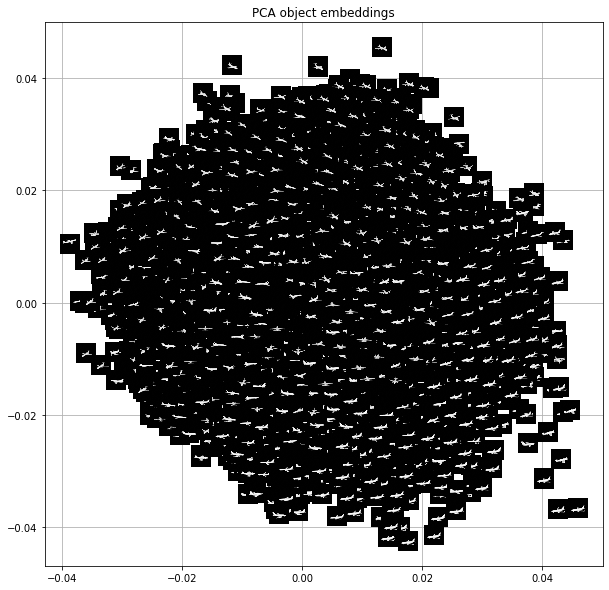

In [29]:
for num_encoding, encoding in enumerate(encoded_list):
    print("Encodings shape", encoding.shape)
    fig, ax = plot_objects_pca(data_class.flat_images, encoding, zoom=0.3)
    ax.grid()
    plt.show();

## Plot the unwrapped embeddings
In the case of datasets with an underlying toroidal structure we can *unwrap* the torus to show the embedded data on the
hyper-dimensional latent space. Since we have a latent space $Z = S^1\times S^1$ consisting of two circles we can plot
the corresponding angle values for each of the embeddings.

In [30]:
if dataset in TORUS_DATASETS:
    print("Plot unwrapped torus")
    # Identify the angles corresponding to the encoding embeddings in each of the circles of the latent space
    unwrapped_angles = np.stack([np.arctan2(encoding[:, 1], encoding[:, 0]) for encoding in encoded_list], axis=-1)
    fig, ax = plot_objects_pca(data_class.flat_images, unwrapped_angles, zoom=0.3)
    ax.grid()
    ax.set_title("Unwrapped torus", fontsize = 25)
    ax.set_xlabel("Angle1", fontsize = 25)
    ax.set_xlabel("Angle2", fontsize = 25)
    # Set x,y angle limits to [-pi,pi]
    ax.set_xlim([-np.pi, np.pi])
    ax.set_ylim([-np.pi, np.pi])
    plt.show();

# Calculate LSBD Metric
Finally, we can calculate the $\mathcal{D}_\mathrm{LSBD}$ metric. We need to define a search space of omega values to
find the most appropriate parameters that define the group action that best fits our encoded data.

In [ ]:
if dataset in TORUS_DATASETS:
    factor_manifold = "torus"
elif dataset in CYLINDER_DATASETS:
    factor_manifold = "cylinder"
else:
    Exception(f"Dataset {dataset} is not within the list of cylinder or torus datasets")
omega_values = create_combinations_omega_values_range(start_value=-10, end_value=10)
dlsbd_value, omega_best = dlsbd(latent_reps, omega_values, be_verbose=False, factor_manifold="torus")
print(f"Metric value {dlsbd_value} obtained by the model")


